In [740]:
import os
import sys
import urllib, io
import pickle

import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.metrics import euclidean_distances, jaccard_score, pairwise_distances

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 
from IPython.core.display import HTML 

from io import BytesIO
import base64
import requests

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

sys.path.append("../../stimuli/block_utils/")
import blockworld_utils as utils

In [741]:
experiment_name = 'build_components'

## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(analysis_dir,'results')

# paths specific to this experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots')
csv_dir = os.path.join(experiment_results_dir,'csv')
json_dir = os.path.join(experiment_results_dir,'json')

png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [742]:
# plot setup
plt.rcParams["figure.figsize"] = (6,4)

In [743]:
# which iteration name should we use?
iteration_name = 'build_components_pilot_2'

### Load csvs from dataframe generator

In [744]:
df_trial = pd.read_csv(experiment_results_dir + '/df_trial_{}.csv'.format(iteration_name))

In [745]:
df_recog = df_trial[df_trial.trial_type == "block-tower-old-new"].reset_index().drop(columns=['index', 'Unnamed: 0'])

In [746]:
df_encode = df_trial[~(df_trial.trial_type == "block-tower-old-new")].reset_index().drop(columns=['index', 'Unnamed: 0'])

In [747]:
df_blocks = pd.read_csv(experiment_results_dir + '/df_blocks_{}.csv'.format(iteration_name))

## Add useful columns

### stimulus info

In [748]:
# import stim dataframes
df_towers = pd.read_csv('../../stimuli/block_utils/ambiguous/ambiguous_composite_towers.csv')

In [749]:
df_towers['tower_id'] = df_towers.tower_id_tall

In [750]:
df_recog = df_recog.merge(df_towers[['tower_id','stim_wide']], on = 'tower_id')
df_recog['square_map'] = df_recog['stim_wide'].apply(lambda x: get_block_map(x))

### Timing data

In [751]:
# df_build['trial_num'] = df_build.trial_index - 3
# df_build['trial_num']

# build_start = df_build[df_build.trial_num == 0][['gameID','trial_start_time']]
# build_start = build_start.rename(columns = {'trial_start_time': 'build_start_time'})

# build_finish = df_build[df_build.trial_num == 15][['gameID','timeAbsolute']]
# build_finish = build_finish.rename(columns= {'timeAbsolute':'build_finish_time'})
# build_timing = build_start.merge(build_finish, on='gameID')
# build_timing['build_duration'] = build_timing['build_finish_time'] - build_timing['build_start_time']
# build_timing['build_duration_min'] = build_timing['build_duration'] / (1000 * 60)
# build_timing

#### export for stats

In [752]:
save = False

if save:
    filename = '../../results/build_components/csv/df_trial_{}.csv'.format(iteration_name)
    df_trial.to_csv(filename)
    print(filename)

# Analysis 

### Analysis setup

### plot setup

In [753]:
sns.set_context('poster')
sns.set(font_scale=1.2)
sns.set_style('whitegrid', {'font.family':'sans-serif', 'font.sans-serif':'Avenir'})

## Key analyses

### Condition difference in accuracy

In [754]:
df_recog['novelty'] = ['new' if condition == 'foil' else 'old' for condition in df_recog.condition]

In [755]:
# double check accuracy calculations
df_recog['response_correct_recalc'] = ((df_recog.response_meaning == 'new') & (df_recog.condition == 'foil')) | \
                                       ((df_recog.response_meaning == 'old') & (df_recog.condition != 'foil'))

df_recog['response_correct_recalc'].equals(df_recog['response_correct'].astype(bool))

True

In [756]:
df_recog.groupby('gameID')['response_correct'].mean().mean()

0.6683333333333333

(0.0, 1.0)

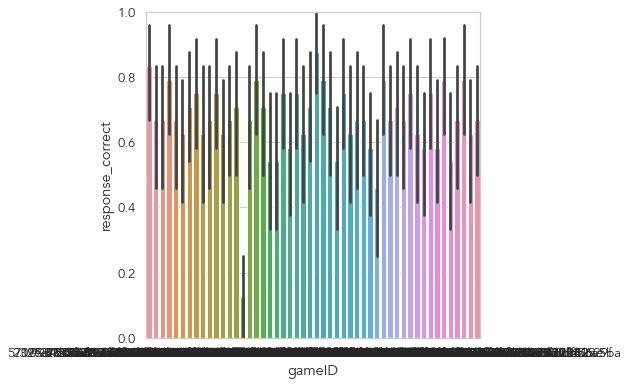

In [757]:
fig = plt.figure(figsize=(6,6))

sns.barplot(data = df_recog, 
            y = "response_correct",
            x = "gameID")
plt.ylim((0,1))

<AxesSubplot:xlabel='condition', ylabel='response_correct'>

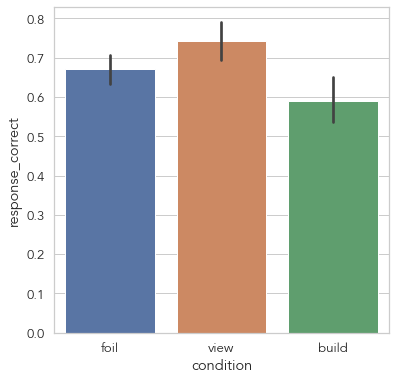

In [758]:
fig = plt.figure(figsize=(6,6))

sns.barplot(data = df_recog, 
            y = "response_correct", 
            x = "condition")

<AxesSubplot:xlabel='gameID', ylabel='response_correct'>

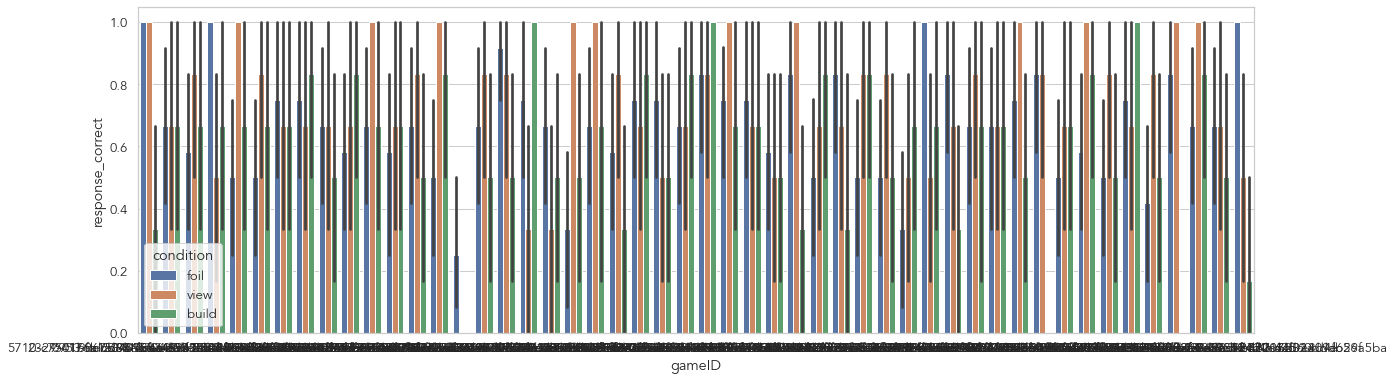

In [759]:
fig = plt.figure(figsize=(20,6))

sns.barplot(data = df_recog, 
            y = "response_correct", 
            x = "gameID",
            hue = "condition")

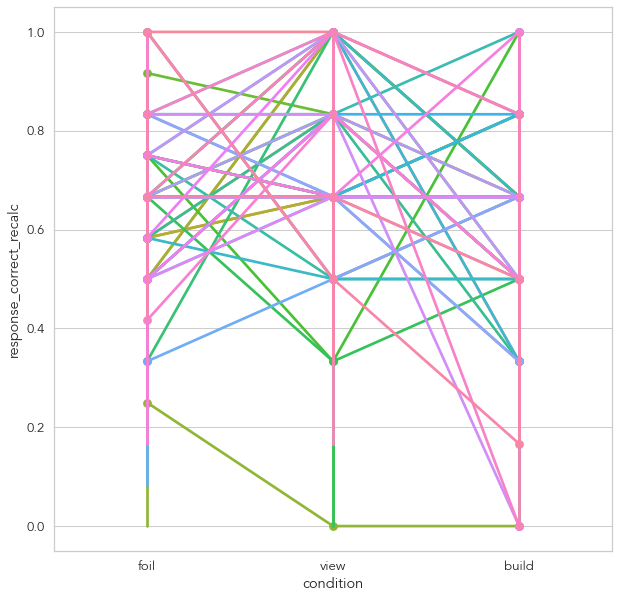

In [760]:
fig = plt.figure(figsize=(10,10))

sns.pointplot(data = df_recog, 
            y = "response_correct_recalc", 
            x = "condition",
            hue="gameID",
            legend="none")
# plt.legend(bbox_to_anchor=(1,1))
plt.legend([],[], frameon=False)


In [761]:
# visualize all responses
# df_recog.groupby('gameID').response.apply(lambda g : ''.join([x for x in g]))

### Condition difference in d'

hit rate H: proportion of YES trials to which subject responded YES =  P("yes" | YES)
false alarm rate F: proportion of NO trials to which subject responded YES  = P("yes" | NO)
d' = z(H) - z(F)


comparing d' for build and view conditions.
In each of these we can look at the hit rate.
But the false alarm rate isn't tied to the hit rate (i.e. false alarms don't have a condition).\


For each participant, for each condition:
- Hit: number of old trials to which ppt responded *old*
- Miss: number of old trials to which ppt responded *new*
- False alarm: number of new trials to which ppt responded *old*
- Correct rejection: number of new trials to which ppt responded *new*

In [762]:
def detection_measures(df_group):
    olds = df_group[df_group.novelty == 'old']
    news = df_group[df_group.novelty == 'new']
    
    # raw counts
    n_hit = len(olds[olds['response_meaning'] == 'old'])
    n_miss = len(olds[olds['response_meaning'] == 'new'])
    n_false_alarm = len(news[news['response_meaning'] == 'old'])
    n_correct_reject = len(news[news['response_meaning'] == 'new'])
    
    return pd.Series({'n_hit': n_hit,
            'n_miss' : n_miss,
            'n_false_alarm' : n_false_alarm,
            'n_correct_reject' : n_correct_reject,
            'n_old_trials' : len(olds),
            'n_new_trials': len(news)
           })

In [763]:
view_measures = df_recog[df_recog.condition.isin(['view','foil'])].groupby(['gameID']).apply(detection_measures)
build_measures = df_recog[df_recog.condition.isin(['build','foil'])].groupby(['gameID']).apply(detection_measures)

view_measures['condition'] = 'view'
build_measures['condition'] = 'build'

view_measures = view_measures.reset_index()
build_measures = build_measures.reset_index()

In [764]:
condition_measures = view_measures.append(build_measures, ignore_index=True)

In [765]:
condition_measures

,gameID,n_hit,n_miss,n_false_alarm,n_correct_reject,n_old_trials,n_new_trials,condition
0,0055-d0778fd4-bbbb-4844-83f2-e7205ae10151,4,2,4,8,6,12,view
1,0090-2fd40afa-1888-4d40-872f-684039d135c5,5,1,2,10,6,12,view
2,0653-f5a64817-a7eb-4b21-8cb9-2de1a2c80902,0,6,9,3,6,12,view
3,0687-78f0cb7d-7793-4ea1-9e38-12b1cfb7c632,5,1,1,11,6,12,view
4,0717-d8a3d2c4-639d-4895-8579-f98799c4a7f0,5,1,2,10,6,12,view
...,...,...,...,...,...,...,...,...
95,9012-5712f831-675d-4ffb-901b-3d7b6a3fc8e4,3,3,5,7,6,12,build
96,9322-e0e5a478-a32d-4cdd-95bf-cf266b74c134,3,3,4,8,6,12,build
97,9863-8d2f7634-ea6e-4abe-95d6-ae0ef5fa02b6,4,2,4,8,6,12,build
98,9963-2ff0d52d-fd46-40cf-8472-587ba3ff6a77,4,2,3,9,6,12,build


In [766]:
from scipy.stats import norm

Z = norm.ppf

In [767]:
def old_new_d_prime(df):
    '''
    Old trials are 'yes' trials. As in 'yes I remember this'.

    For this design, F will be the same for both conditions (build and view).
    '''
    H = df['n_hit'] / df['n_old_trials']
    
    # replace HIT rates to avoid inf d-prime
    if H == 1: 
        H = 0.9999
    if H == 0:
        H = 0.0001
    
    
    F = df['n_false_alarm'] / df['n_new_trials'] 
    
    # replace FA rates to avoid inf d-prime
    if F == 1: 
        F = 0.9999
    if F == 0: 
        F = 0.0001
    
    d_prime = Z(H) - Z(F)
    
    return d_prime

In [768]:
condition_measures['d_prime'] = condition_measures.apply(lambda row: old_new_d_prime(row), axis=1)

<AxesSubplot:xlabel='condition', ylabel='d_prime'>

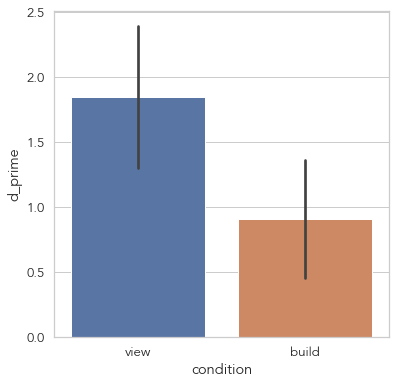

In [769]:
fig = plt.figure(figsize=(6,6))

sns.barplot(data = condition_measures, 
            y = "d_prime", 
            x = "condition")

In [770]:
condition_measures.groupby('condition')['d_prime'].mean()

condition
build    0.905926
view     1.846695
Name: d_prime, dtype: float64

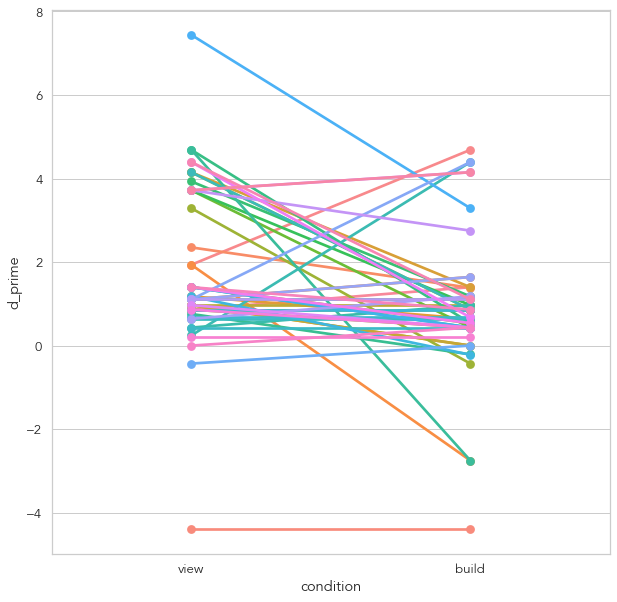

In [771]:
fig = plt.figure(figsize=(10,10))

sns.pointplot(data = condition_measures, 
            y = "d_prime", 
            x = "condition",
            hue = "gameID")

plt.legend([],[], frameon=False)

### Effect of tower

In [772]:
def show_tower(url, ax):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
#     plt.figure(figsize=(2,1))
    ax.imshow(img)
    ax.axis('off')
    
def show_tower_subplot(tower_id,
                      ax,
              url_stem = "https://zipping-composites-monochrome-png-rerender.s3.amazonaws.com/tower_4_block_unique_silhouettes_composites_monochrome_png_rerender_{}.png"):
    
    response = requests.get(url_stem.format(tower_id))
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(tower_id)
    

In [773]:
tower_ids = list(np.sort(df_recog.tower_id.unique()))

Text(0.5, 1.0, '')

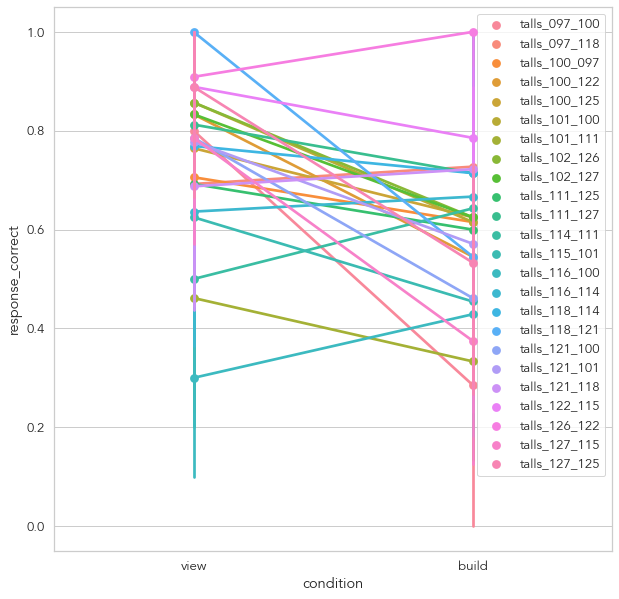

In [774]:
plt.figure(figsize = (10,10))
sns.pointplot(data = df_recog[df_recog.condition != 'foil'],
            y = 'response_correct',
            x = 'condition',
            hue = 'tower_id',
            hue_order=tower_ids)
# plt.xticks(rotation = 45)
plt.legend(bbox_to_anchor = (1,1))

plt.title('')

No handles with labels found to put in legend.


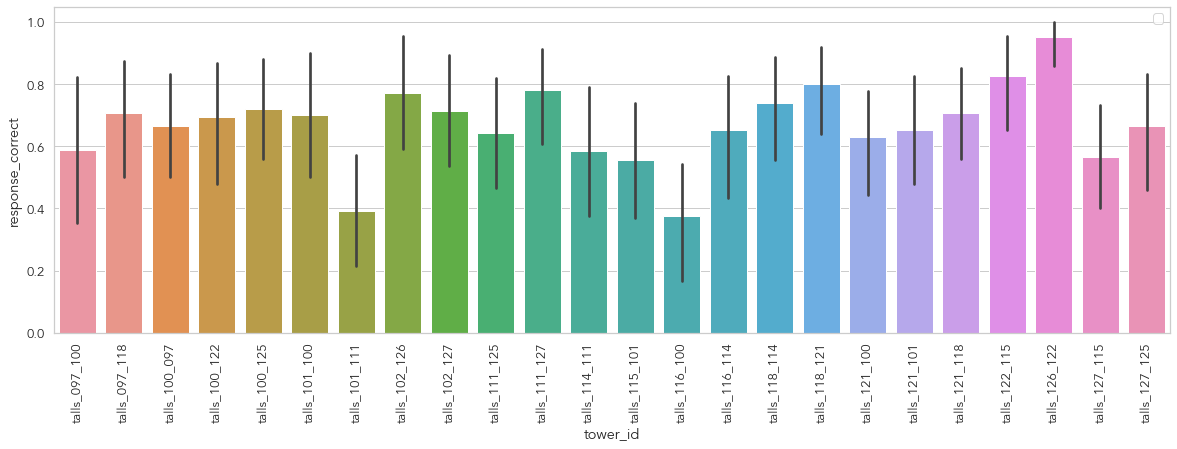

In [775]:
plt.figure(figsize = (20,6))
sns.barplot(data = df_recog[df_recog.condition != 'foil'],
            y = 'response_correct',
            x = 'tower_id',
#             hue = 'condition',
            order=tower_ids)
plt.xticks(rotation = 90)
plt.legend(bbox_to_anchor = (1,1))

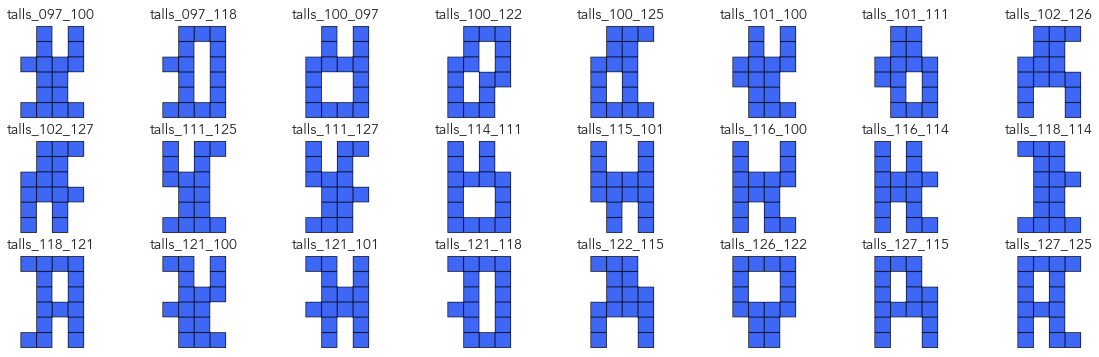

In [535]:
n_row = 3
fig, axs = plt.subplots(n_row, int(len(tower_ids)/n_row), figsize=(20,6))

for i, tower in enumerate(tower_ids):
    show_tower_subplot(tower, axs[int(np.floor(i/(len(tower_ids)/n_row))), i%(int(len(tower_ids)/n_row))])

## Building measures

#### Build time

relative_time: time between start and end of building trial. This includes *all* attempts, i.e. time including resets.

In [776]:
df_build = df_encode[df_encode.trial_type == 'block-tower-building']

In [777]:
build_times = df_build.groupby('gameID')[['relative_time']].mean().reset_index()

<AxesSubplot:xlabel='gameID', ylabel='relative_time'>

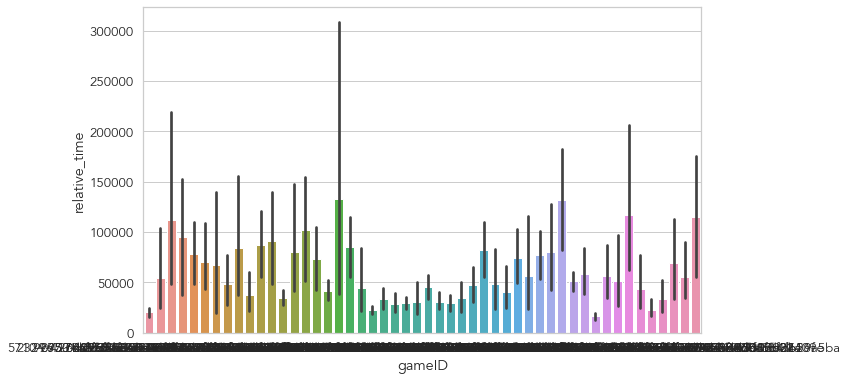

In [778]:
plt.figure(figsize =(10,6))

sns.barplot(data = df_build,
            x = 'gameID',
            y = 'relative_time',
            )

<AxesSubplot:xlabel='relative_time', ylabel='Count'>

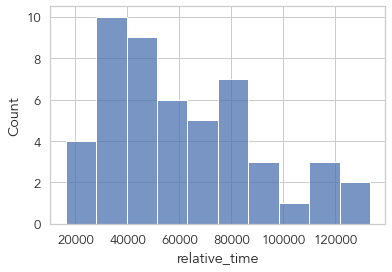

In [779]:
sns.histplot(build_times,
            x = 'relative_time',
            log_scale=False,
            bins=10)

In [780]:
build_times.mean()

<ipython-input-780-904635fd3750>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  build_times.mean()


relative_time    61080.26
dtype: float64

Average build time is a lot longer than the 15 seconds people have to view the structure. 

### Resets

In [781]:
reset_means = df_build.groupby('gameID')[['n_resets']].mean().reset_index()

<AxesSubplot:xlabel='n_resets', ylabel='Count'>

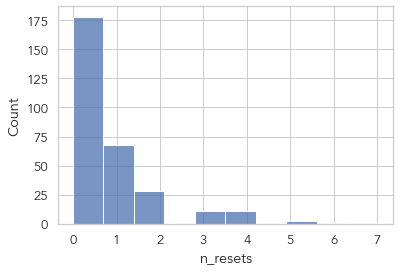

In [782]:
# raw trials
sns.histplot(df_build,
            x = 'n_resets',
            log_scale=False,
            bins=10)

<AxesSubplot:xlabel='n_resets', ylabel='Count'>

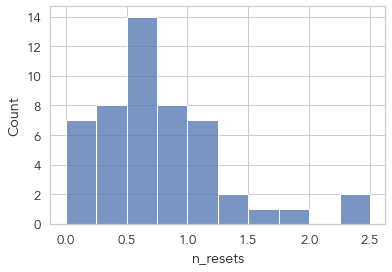

In [783]:
# mean for ppts
sns.histplot(reset_means,
            x = 'n_resets',
            log_scale=False,
            bins=10)

## Time measures

These plots seem to suggest that the longer you wait between encoding and recall, the worse your memory of that item.

In [784]:
# this dataframe contains recognition trials only from targets (i.e. non-foils)
# it is augmented with additional variables from here onwards
df_recog_target = df_recog[df_recog.condition != 'foil']

#### Encoding trial number

Were the targets that were viewed/ built later remembered better?
Looks like that may be the case.
Also looks like a slight primacy bias?

In [785]:
df_encode['encode_trial_num'] = df_encode.trial_num

In [786]:
df_recog_target = df_recog_target.merge(df_encode[df_encode.condition != 'foil']\
                                        [['gameID', 'tower_id','encode_trial_num']], 
                                        on = ['gameID','tower_id'])

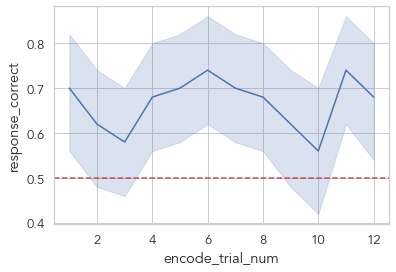

In [787]:
sns.lineplot(data = df_recog_target,
                x = 'encode_trial_num',
                y = 'response_correct')
plt.axhline(0.5, color = 'r', linestyle = '--',)

#### Recog trial number

Were the targets that were probed earlier remembered better?

In [788]:
df_recog['recog_trial_num'] = df_recog.trial_num - 12

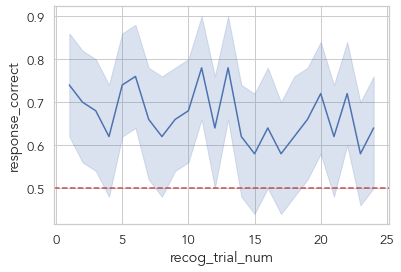

In [789]:
sns.lineplot(data = df_recog,
                x = 'recog_trial_num',
                y = 'response_correct')
plt.axhline(0.5, color = 'r', linestyle = '--',)

#### Number of trials between encoding and recognition

Were the targets with a smaller gap (number of trials) between encoding and recognition better remembered?

Eyeballing this graph it does look like the longer between encoding and recognition trials, the worse the performance.

In [790]:
def trial_diff(df, col='trial_num'):
    return df[col].max() - df[col].min()

In [791]:
trial_diffs = df_trial[df_trial.condition != 'foil'].groupby(['gameID','tower_id']).apply(trial_diff).reset_index()

In [792]:
trial_diffs = trial_diffs.rename(columns = {0: 'trial_diff'})

In [793]:
df_recog_target = df_recog_target.merge(trial_diffs, on=['gameID','tower_id'])

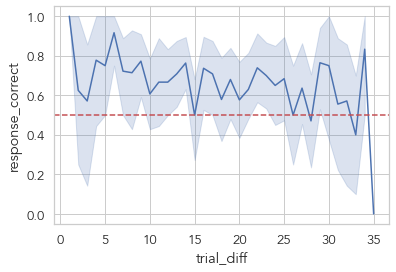

In [794]:
sns.lineplot(data = df_recog_target,
                x = 'trial_diff',
                y = 'response_correct')

plt.axhline(0.5, color = 'r', linestyle = '--',)

#### Duration between encoding and recognition

Were the targets with a smaller gap (absolute time) between encoding and recognition better remembered?

In [795]:
trial_time_diffs = df_trial[df_trial.condition != 'foil']\
    .groupby(['gameID','tower_id']).apply(lambda group: trial_diff(group, col='trial_start_time')).reset_index()

In [796]:
trial_time_diffs = trial_time_diffs.rename(columns = {0: 'trial_time_diff'})

In [797]:
df_recog_target = df_recog_target.merge(trial_time_diffs, on=['gameID','tower_id'])

In [798]:
df_recog_target['trial_time_diff_bin'] = pd.cut(df_recog_target.trial_time_diff, 10)

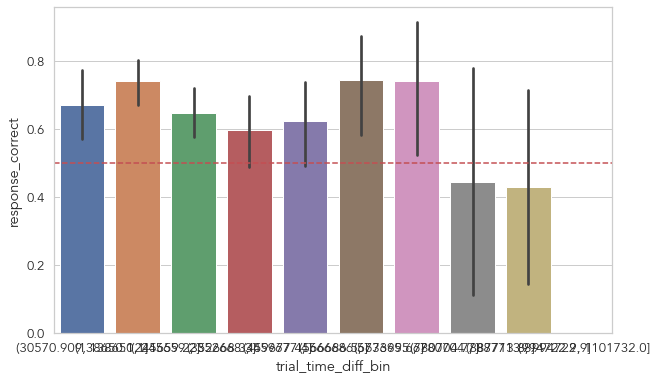

In [799]:
plt.figure(figsize=(10,6))

sns.barplot(data = df_recog_target,
                x = 'trial_time_diff_bin',
                y = 'response_correct')

plt.axhline(0.5, color = 'r', linestyle = '--',)

In [800]:
df_recog_target['trial_log_time_diff_bin'] = pd.cut(np.log(df_recog_target.trial_time_diff), 10)

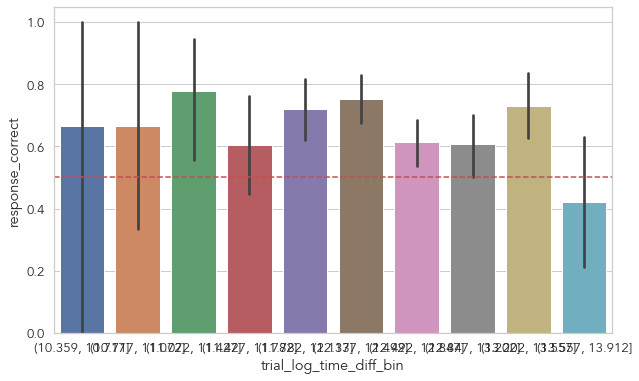

In [801]:
plt.figure(figsize=(10,6))

sns.barplot(data = df_recog_target,
                x = 'trial_log_time_diff_bin',
                y = 'response_correct')

plt.axhline(0.5, color = 'r', linestyle = '--',)

### Check for reasonable distribution of temporal differences between conditions

In [802]:
df_condition_means = df_recog_target.groupby(['gameID','condition']).mean().reset_index()

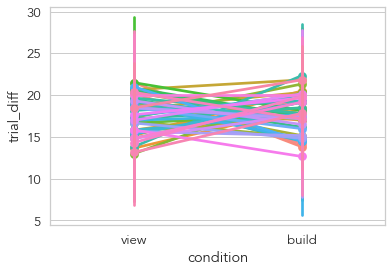

In [803]:
sns.pointplot(data = df_recog_target,
            x = 'condition',
            y = 'trial_diff',
            hue = 'gameID')
plt.legend([],[], frameon=False)

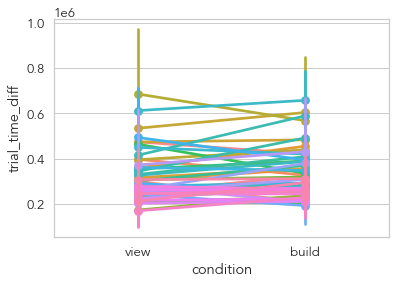

In [804]:
sns.pointplot(data = df_recog_target,
            x = 'condition',
            y = 'trial_time_diff',
            hue = 'gameID')
plt.legend([],[], frameon=False)

In [805]:
def condition_diff(df, cols = ['d_prime']):
    '''
    Returns difference between build and view conditions for variables in cols
    '''
#     print(df.condition)
    
    diffs = df[df.condition=='view'][cols].iloc[0] - df[df.condition=='build'][cols].iloc[0] 
    
    
    diffs = diffs.rename({col : col + '_diff' for col in cols})
    
    return diffs

In [806]:
# used below as predictor of d' differences
condition_time_diffs = df_condition_means.groupby(['gameID']).apply(lambda df: condition_diff(df, cols = ['trial_diff',
                                                                                   'recog_trial_num' ,
                                                                                   'encode_trial_num',
                                                                                   'trial_time_diff']))

KeyError: "['recog_trial_num'] not in index"

## Explore reasons for larger differences in d' between view and build

In [807]:
condition_measures_diffs = condition_measures_expanded.groupby('gameID').apply(condition_diff)

In [808]:
ppt_accuracy = df_recog.groupby('gameID')[['response_correct']].mean().reset_index()

In [809]:
condition_measures_diffs = condition_measures_diffs.copy().merge(ppt_accuracy, on='gameID')\
                                                   .merge(build_times, on='gameID')\
                                                   .merge(reset_means, on='gameID')\
                                                   .merge(condition_time_diffs, on = 'gameID')

In [810]:
condition_measures_diffs

,gameID,d_prime_diff,response_correct,relative_time,n_resets,trial_diff_diff,recog_trial_num_diff,encode_trial_num_diff,trial_time_diff_diff
0,0055-d0778fd4-bbbb-4844-83f2-e7205ae10151,-0.536694,0.708333,29677.500000,0.333333,-7.333333,-8.666667,-1.333333,-24412.666667
1,0090-2fd40afa-1888-4d40-872f-684039d135c5,-2.751595,0.875000,30506.500000,0.166667,-2.000000,-2.333333,-0.333333,-6564.166667
2,0653-f5a64817-a7eb-4b21-8cb9-2de1a2c80902,0.000000,0.125000,73574.500000,1.333333,-2.666667,-3.000000,-0.333333,-40396.333333
3,0687-78f0cb7d-7793-4ea1-9e38-12b1cfb7c632,0.967422,0.791667,80337.666667,0.833333,-1.166667,-0.500000,0.666667,-69554.333333
4,0717-d8a3d2c4-639d-4895-8579-f98799c4a7f0,4.686438,0.625000,82261.500000,1.333333,-1.333333,-0.666667,0.666667,-78534.333333
5,0749-c3d79b55-75ae-425d-9f3d-cbaab6718589,-0.536694,0.750000,28942.000000,0.166667,1.833333,2.500000,0.666667,-7236.666667
6,0953-ddcb856a-a699-47a3-8f7d-700ee645c217,0.536694,0.666667,94979.500000,2.500000,6.000000,4.333333,-1.666667,52671.333333
7,1499-fc108b72-fd66-4924-955f-d7017b01409e,2.751595,0.791667,55423.000000,0.333333,4.833333,5.166667,0.333333,-18185.166667
8,1642-2aa7cfec-1f16-4800-bc72-f624fc299a74,0.967422,0.583333,16266.333333,0.000000,3.333333,3.666667,0.333333,11829.166667
9,1907-16ede4a4-7b27-4077-bc0d-8aba40333924,0.967422,0.583333,23051.333333,0.166667,-5.500000,-3.833333,1.666667,-58661.500000


#### distribution of differences in d' between conditions.
Positive difference indicates that d' was greater for view condition

<AxesSubplot:xlabel='d_prime_diff', ylabel='Count'>

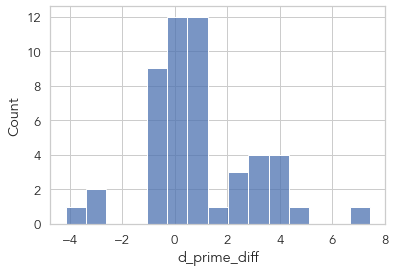

In [811]:
sns.histplot(condition_measures_diffs.d_prime_diff, bins=15)

#### Temporal differences

<AxesSubplot:xlabel='trial_diff_diff', ylabel='d_prime_diff'>

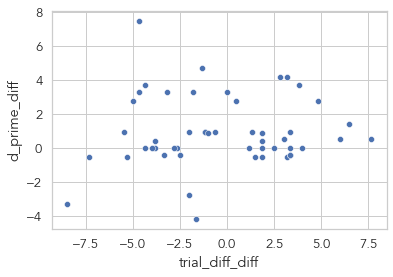

In [812]:
# average number of trials between encoding and recognition
sns.scatterplot(data = condition_measures_diffs,
                x = 'trial_diff_diff',
                y = 'd_prime_diff')

<AxesSubplot:xlabel='trial_time_diff_diff', ylabel='d_prime_diff'>

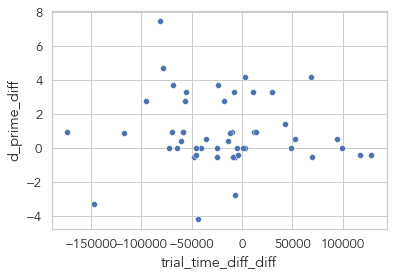

In [813]:
# average time between encoding and recognition
sns.scatterplot(data = condition_measures_diffs,
                x = 'trial_time_diff_diff',
                y = 'd_prime_diff')

<AxesSubplot:xlabel='encode_trial_num_diff', ylabel='d_prime_diff'>

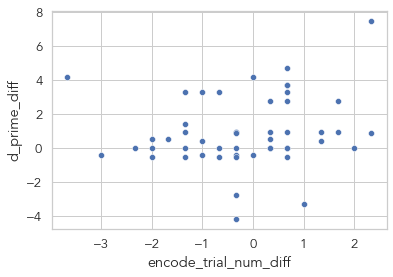

In [814]:
# are encoding trials just later for view condition? Nope
sns.scatterplot(data = condition_measures_diffs,
                x = 'encode_trial_num_diff',
                y = 'd_prime_diff')

<AxesSubplot:xlabel='recog_trial_num_diff', ylabel='d_prime_diff'>

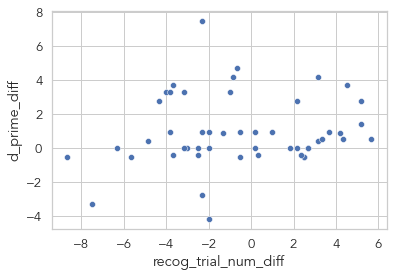

In [815]:
# are recogntion trials just earlier for view condition? Nope
sns.scatterplot(data = condition_measures_diffs,
                x = 'recog_trial_num_diff',
                y = 'd_prime_diff')

#### average build time

<AxesSubplot:xlabel='relative_time', ylabel='d_prime_diff'>

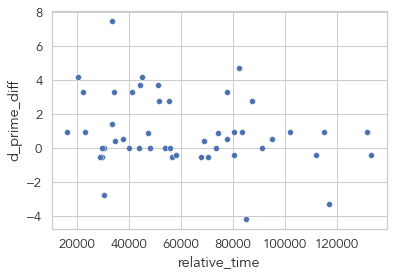

In [816]:
sns.scatterplot(data = condition_measures_diffs,
                x = 'relative_time',
                y = 'd_prime_diff')

#### average number of resets

<AxesSubplot:xlabel='n_resets', ylabel='d_prime_diff'>

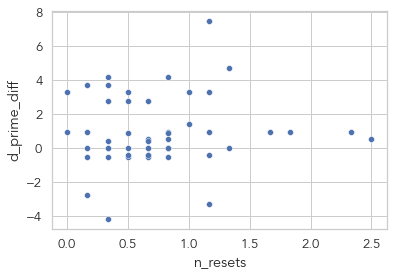

In [817]:
sns.scatterplot(data = condition_measures_diffs,
                x = 'n_resets',
                y = 'd_prime_diff')

#### average accuracy

<AxesSubplot:xlabel='response_correct', ylabel='d_prime_diff'>

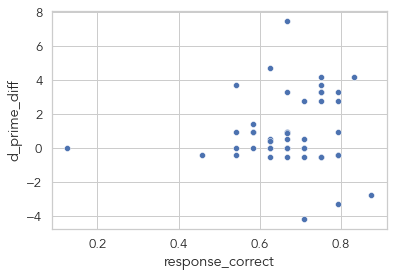

In [818]:
sns.scatterplot(data = condition_measures_diffs,
                x = 'response_correct',
                y = 'd_prime_diff')

## Properties of stimuli/ kinds of errors

### Holistic measures of similarity

In [825]:
### Measures

def jaccard_distance(a, b):
    return 1 - jaccard_score(a, b, average = 'micro')

def euclidean_distance(a, b):
    return math.dist(a.flatten(), b.flatten())

def euc_2(a, b):
    return np.linalg.norm(a-b)

 
### Utils

def get_block_map(blocks):
    return utils.worldify(ast.literal_eval(blocks)).block_map[2:,0:4]

def mean_tower(group):
    return np.mean(group['square_map'])


### Calculate variabilities

def between_group_var(group_a, group_b, metric = euc_2):
    
    both_groups = group_a.copy().append(group_b.copy(), ignore_index = True)
    
    y_bar = mean_tower(both_groups)
    
    group_a_mean = mean_tower(group_a)
    group_b_mean = mean_tower(group_b)
    
    inside_sum = [(len(group_a) * ((metric(group_a_mean, y_bar))**2)), (len(group_b) * ((metric(group_b_mean, y_bar))**2))]
    
#     distances = np.array([[jaccard_distance(tower_a, tower_b) for tower_b in group_a['square_map']] for tower_a in group_b['square_map']])
    
#     squared_distances = np.square(distances)

    var = np.sum(inside_sum)
    
    return var
    

def within_group_var(group_a, group_b, metric = euc_2):
    '''
    Calculates variance using errors i.e. distances from the mean,
    where mean is literally the pointwise mean the map of blocks
    
    e.g. mean of these
    [[0, 0, 0, 0],      [[0, 0, 0, 0],
     [0, 1, 1, 0],       [0, 0, 0, 0],
     [0, 1, 1, 0],       [0, 1, 1, 1],
     [0, 1, 1, 0]]       [0, 1, 1, 1]] 

    is:
    [[0, 0, 0, 0],
     [0,.5,.5, 0],
     [0, 1, 1,.5],
     [0, 1, 1,.5]]
     
    This means we can't use jaccard or any other measure of similarity that requires discrete values.
    '''
    
    total_observations = len(group_a) + len(group_b)
    
    group_vars = []
    
    for group in [group_a, group_b]:
        
        group_mean = mean_tower(group)

        errors = group['square_map'].apply(lambda tower: metric(tower, group_mean))
        
        sqrd_errors = np.square(errors)

        sum_sqrd_errors = np.sum(sqrd_errors)
        
        group_var = sum_sqrd_errors/(total_observations - 2) # 2 is number of groups
        
        group_vars.append(group_var)
    
    sum_vars = sum(group_vars)
    
    return sum_vars


def get_variabilities(df, metric = euc_2):
    
    # group contains recall trials from a single ppt
    
    build_group = df[df.condition == 'build']
    view_group  = df[df.condition == 'view']
    foil_group  = df[df.condition == 'foil']
    
    group_variabilities = {
        'build_between_group_var' : between_group_var(build_group, foil_group, metric = metric),
        'build_within_group_var' : within_group_var(build_group, foil_group, metric = metric),
        'view_between_group_var'  : between_group_var(view_group, foil_group, metric = metric),
        'view_within_group_var'  : within_group_var(view_group, foil_group, metric = metric),
    }
    
    group_variabilities['build_f_ratio'] = group_variabilities['build_between_group_var'] / group_variabilities['build_within_group_var']
    group_variabilities['view_f_ratio'] = group_variabilities['view_between_group_var'] / group_variabilities['view_within_group_var']
    
    return pd.Series(group_variabilities)

In [863]:
a = np.array([1,1,3])
b = np.array([1,2,2])

euc_2(a,b)

1.4142135623730951

#### Euclidean Distance

In [850]:
df_variabilities = df_recog.groupby(['gameID']).apply(\
                        lambda group : get_variabilities (group, metric = euc_2)).reset_index()     

In [851]:
# tidy dataframe
build_variabilities = df_variabilities[['build_between_group_var','build_within_group_var','build_f_ratio','gameID']].copy()
build_variabilities['condition'] = 'build'
view_variabilities = df_variabilities[['view_between_group_var','view_within_group_var','view_f_ratio','gameID']].copy()
view_variabilities['condition'] = 'view'

build_variabilities = build_variabilities.rename(columns = {'build_between_group_var': 'between_group_var',
                                      'build_within_group_var': 'within_group_var',
                                      'build_f_ratio': 'f_ratio'})

view_variabilities = view_variabilities.rename(columns = {'view_between_group_var': 'between_group_var',
                                     'view_within_group_var': 'within_group_var',
                                     'view_f_ratio': 'f_ratio'})

df_variabilities_tidy = build_variabilities.append(view_variabilities, ignore_index=True)
df_variabilities_tidy['measure'] = 'euclidean'
df_variabilities_tidy

,between_group_var,within_group_var,f_ratio,gameID,condition,measure
0,7.555556,4.854167,1.556509,0055-d0778fd4-bbbb-4844-83f2-e7205ae10151,build,euclidean
1,3.277778,5.197917,0.630595,0090-2fd40afa-1888-4d40-872f-684039d135c5,build,euclidean
2,10.166667,4.864583,2.089936,0653-f5a64817-a7eb-4b21-8cb9-2de1a2c80902,build,euclidean
3,3.611111,5.114583,0.706042,0687-78f0cb7d-7793-4ea1-9e38-12b1cfb7c632,build,euclidean
4,8.000000,4.979167,1.606695,0717-d8a3d2c4-639d-4895-8579-f98799c4a7f0,build,euclidean
...,...,...,...,...,...,...
95,6.111111,5.000000,1.222222,9012-5712f831-675d-4ffb-901b-3d7b6a3fc8e4,view,euclidean
96,4.388889,5.114583,0.858113,9322-e0e5a478-a32d-4cdd-95bf-cf266b74c134,view,euclidean
97,3.500000,5.135417,0.681542,9863-8d2f7634-ea6e-4abe-95d6-ae0ef5fa02b6,view,euclidean
98,4.222222,5.229167,0.807437,9963-2ff0d52d-fd46-40cf-8472-587ba3ff6a77,view,euclidean


# Export condition measures csvs

In [852]:
condition_measures_expanded = condition_measures.copy().merge(df_variabilities_tidy, on = ['gameID','condition'])

In [853]:
condition_measures_expanded.to_csv('../../results/build_components/csv/df_condition_measures_{}.csv'.format(iteration_name))

In [854]:
df_recog.to_csv('../../results/build_components/csv/df_recog_{}.csv'.format(iteration_name))

<AxesSubplot:xlabel='f_ratio', ylabel='d_prime'>

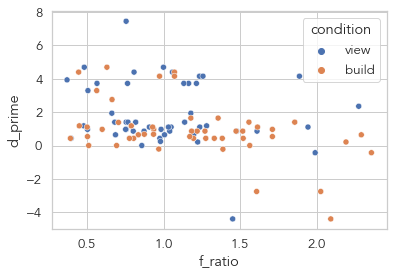

In [855]:
sns.scatterplot(
    data = condition_measures_export,
    x = 'f_ratio',
    y = 'd_prime',
    hue = 'condition'
)

#### More likely to make mistake if built/ viewed chunk?

Lots of these towers shared parts (i.e. top or bottom half) with other towers. Are people more likely to false alarm if they have:
- viewed a shared part previously
- built a shared part previously
- built or viewed a shared part previously
- built or viewed a shared part more times (i.e. ordinal predictor)

In [143]:
# df_parts = \
#     df_recog.groupby(['gameID','condition'])['tower_A_wide_id'].apply(pd.unique).reset_index().merge(\
#     df_recog.groupby(['gameID','condition'])['tower_B_wide_id'].apply(pd.unique).reset_index(), 
#     on = ['gameID','condition'])


# df_parts.apply(lambda row: (list(row['tower_A_wide_id']) + list(row['tower_B_wide_id'])), axis = 1)

In [144]:
# which parts have been seen before?
old_part_bottom = df_recog.groupby(['gameID','condition']).apply(lambda row: list(pd.unique(row['tower_A_wide_id']))).reset_index()
old_part_top = df_recog.groupby(['gameID','condition']).apply(lambda row: list(pd.unique(row['tower_B_wide_id']))).reset_index()
old_part_either = df_recog.groupby(['gameID','condition']).apply(\
                lambda row: list(pd.unique(row['tower_A_wide_id'].append(row['tower_B_wide_id'])))).reset_index()

In [122]:
# careful here: you can view and build only one of the parts (don't just sum these)
# (but you can sum them to find number of times that part was built for familiarity)
n_parts_viewed = ...
n_parts_built = ...

n_times_part_seen = 0 # calculated differently! not with unique used above



### Jaccard similarity

Is it harder to remember stimuli that are similar to each other?

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html

In [ ]:
# You cannot calculate the Jaccard score between continuous variables

# df_variabilities = df_recog.groupby(['gameID']).apply(\
#                         lambda group : get_variabilities (group, metric = jaccard_distance)).reset_index()                                                      

### Other

### Other

### Other